In [101]:
import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from cycler import cycler
from importlib import reload
from functools import partial
# source modules and classes being developed 
import package
from package import utils, visualize
from package.writhe.writhe import Writhe
from package.msmtool.msmtool import (microstate_indices, cluster_similarity,
                                     _tcca_scores, canonical_sign)


from package.utils.utils import (lsdir, group_by,
                                 indices_stat, sort_by_val_in,
                                 reindex_list, sort_indices_list,
                                 count_int_arr, load_dict, load_array_dir)


In [58]:
#load data into dictionary
paths=["/home/t/writhe/asyn/full/apo/data/tcca/",
       "/home/t/writhe/actr/data/tcca/",
       "/home/t/writhe/hp35/data/tcca/",
        "/home/t/writhe/ntail/data/tcca/"]

tcca_scores = {i : dict(path=j) for i,j in zip(["asyn", "actr", "hp35", "ntail"], paths)}

keyword = "val"            
formatter = lambda k : k if int(k) <= 10 else ",".join(str(k))
file_to_key = lambda k : formatter(utils.num_str(utils.rm_path(k)))

for key, value in tcca_scores.items():
            
    #writhe
    value.update({file_to_key(dir): load_array_dir(dir, keyword=keyword, stack=True)
                 for dir in lsdir(value["path"]+"writhe", "length")})
    #distances
    value.update(dict(distances=load_array_dir(value["path"]+"distances", keyword=keyword, stack = True)))

 # Time correlations

Text(0.02, 0.5, 'Kinetic Variance')

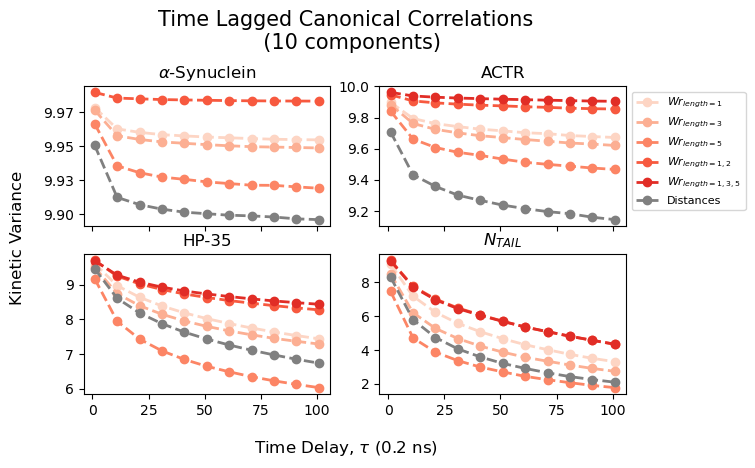

In [55]:
fig, axes = plt.subplots(2,2,figsize=(7,4),sharey=False, sharex=True)
names = [r"$\alpha$-Synuclein", "ACTR", "HP-35", r"$N_{TAIL}$"]
for ax, name,  (key, value) in zip(axes.flat, names, tcca_scores.items()):
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(6,
                                                             "Reds",
                                                              trunc=50,
                                                              pre_trunc=40))))
    ax.set_title(name)
    
    if name == r"$\alpha$-Synuclein":
        ax.yaxis.set_major_formatter('{x:.2f}')

    for k, v in value.items():
        if k not in ("path", "distances"):
            if (((not "," in str(k)) and (int(k)>3 or int(k)==2))
                or (k in ("1,2,3","1,2,3,4", "1,2,3,4,5"))) and k!=5:continue
                
            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label=f"$Wr$$_{{length={k}}}$",
                    lw=2,
                    ls="--",
                    marker="o")
            #ax.legend(bbox_to_anchor=[1,1], fontsize=8)
        
        if k == "distances":
            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label="Distances",
                    lw=2,
                    ls="--",
                    marker="o",
                    color="gray")
        #ax.set_xticks(np.linspace(1,111,11), labels=)

axes[0,-1].legend(bbox_to_anchor=[1,1],
                  fontsize=8)
fig.supxlabel(r"Time Delay, $\tau$ (0.2 ns)", y=-0.05)

fig.suptitle("Time Lagged Canonical Correlations\n  (10 components)",
             fontsize=15,y=1.07)

fig.supylabel("Kinetic Variance",
              y=0.5,x=0.02)
#plt.savefig("/home/t/writhe/tcca_comp_fig.png", dpi=1300, bbox_inches="tight")

 # Showing the effect of combining writhe datasets on latent spaces

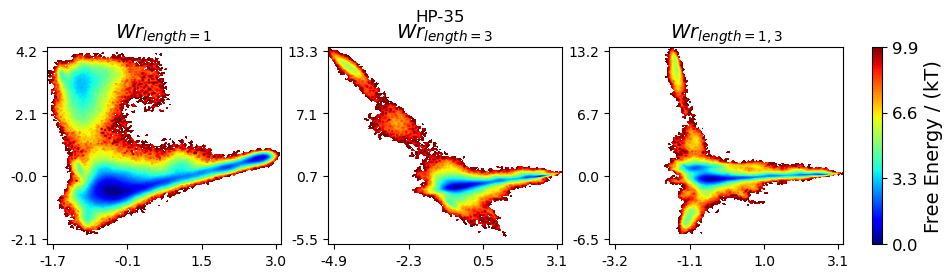

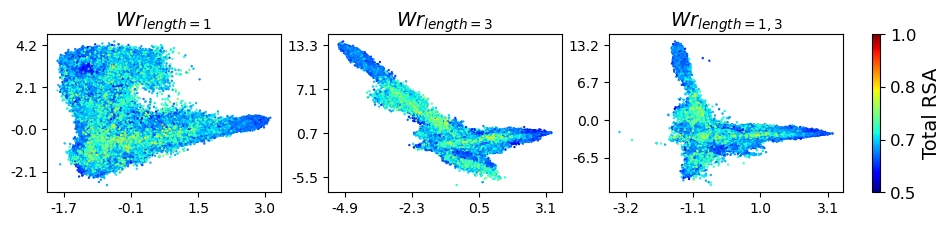

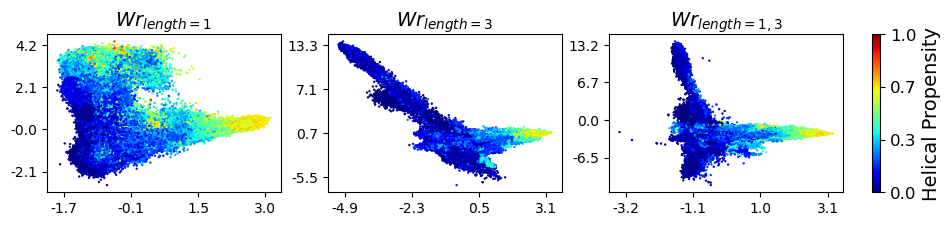

In [116]:
# reload(package)
# reload(package.visualize)
# from package.visualize.visualize import subplots_fes2d
rsa = np.load("/home/t/writhe/hp35/data/observables/rsa.npy")
sa = np.load("/home/t/writhe/hp35/data/observables/sa.npy")
# grab the projections of interest
data = np.stack([load_array_dir(lsdir(f"{paths[-2]}writhe",
                                      keyword=f"_{i}",
                                      match=all)[0],
                                
                                keyword=["lag_31", "proj"],
                                stack=True).squeeze()
         
                 for i in [1,2,3,4,13]])[...,:2]

data = np.stack(list(map(canonical_sign,data)))

font_scale=1

visualize.subplots_fes2d(data,
                         indices_list = [0,2,4],
                         rows=1,
                         cols=3,
                         dscrs=[f"$Wr$$_{{length={i}}}$" for i in [1,3,"1,3"]],
                         share_extent=False,
                         mask=True,
                         bins=150,
                         figsize=(10.5,2.5),
                         title = "HP-35",
                         font_scale=font_scale)

#plt.savefig("/home/t/writhe/hp35/fes", dpi=1300, bbox_inches="tight")


nrsa = rsa.sum(1); nrsa /= nrsa.max()
nsa = sa.sum(1); nsa /= nsa.max()

subplots_proj2d(data,
                c=nrsa,
                indices_list = [0,2,4],
                rows=1,
                cols=3,
                dscrs=[f"$Wr$$_{{length={i}}}$" for i in [1,3,"1,3"]],
                share_extent=False,
                bins=150,
                figsize=(10.5,2),
                cbar_label="Total RSA",
                font_scale=font_scale)

subplots_proj2d(data,
                c=nsa,
                indices_list = [0,2,4],
                rows=1,
                cols=3,
                dscrs=[f"$Wr$$_{{length={i}}}$" for i in [1,3,"1,3"]],
                share_extent=False,
                bins=150,
                figsize=(10.5,2),
                cbar_label="Helical Propensity",
                #cbar_label=r"$S_{\alpha}$",
                font_scale=font_scale,)
#plt.savefig("/home/t/writhe/hp35/fes", dpi=1300, bbox_inches="tight")



#plt.savefig("/home/t/writhe/hp35/rsa", dpi=1300, bbox_inches="tight")

 # Visualize most promising tCCA free energy surfaces for Writhe combinations and Distances

In [182]:
# get files
tcca_projections = {key:{} for key in tcca_scores.keys()}
lengths = [12, 135, 13, 12345]
lags = [21, 31, 31, 11]

for length, lag, value, path in zip(lengths, lags, tcca_projections.values(), paths):
    
    kws = [f"lag_{lag}", "proj"]
    
    value["writhe"] = load_array_dir(lsdir(f"{path}writhe",
                                           str(length))[0],
                                     kws,
                                     stack=True).squeeze()
    
    value["distances"] = load_array_dir(f"{path}distances", kws, stack=True).squeeze()
    


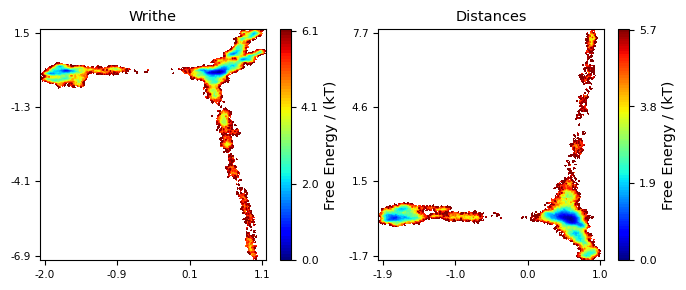

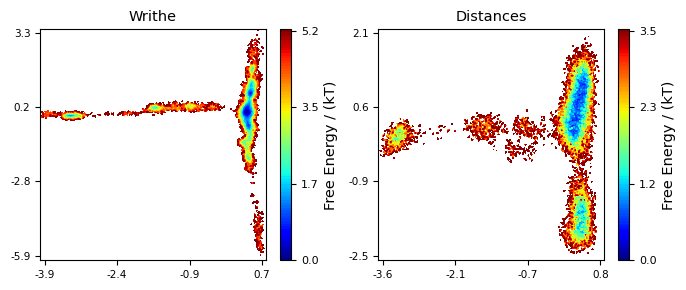

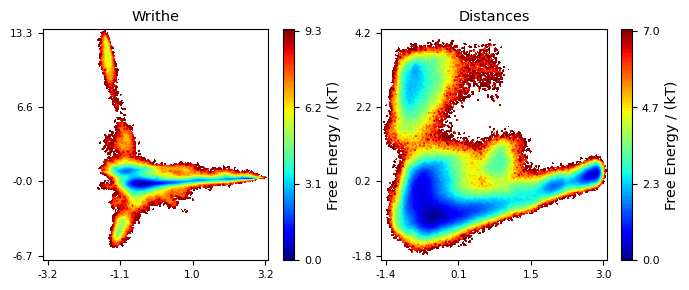

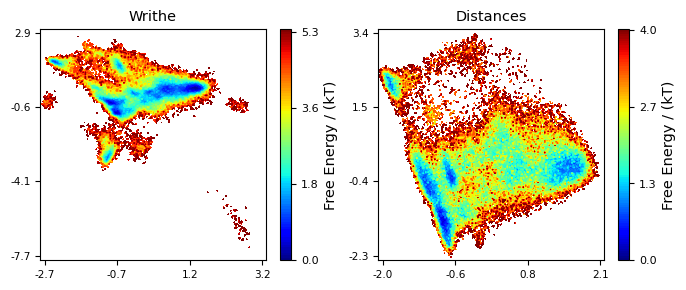

In [120]:
for value, name in zip(tcca_projections.values(), names):
    
    efig, axes = plt.subplots(1, 2, figsize=(8,3))
    ax = axes.flat
    
    fes2d(canonical_sign(value["writhe"][:,:2]),
          ax=ax[0],
          font_scale=.75,
          title="Writhe",
          bins=200,
          n_contours=100)
    
    fes2d(canonical_sign(value["distances"][:,:2]),
          ax=ax[1],
          font_scale=.75,
          title="Distances",
          bins=200,
          n_contours=100)
    
    fig.tight_layout()
    fig.suptitle(name, y = 1.1)

 # Estimate MSMs using set hyperparameters

In [159]:
tcca_projections = {key:{} for key in tcca_scores.keys()}
lengths = [123, 13, 135, 12345]
lags = [31, 11, 31, 11]

for length, lag, value, path in zip(lengths, lags, tcca_projections.values(), paths):
    
    kws = [f"lag_{lag}", "proj"]
    
    value["writhe"] = load_array_dir(lsdir(f"{path}writhe",
                                           str(length))[0],
                                     kws,
                                     stack=True).squeeze()
    
    value["distances"] = load_array_dir(f"{path}distances", kws, stack=True).squeeze()

#clustering
dims = [4,4,4,4]
n = 50
msms = deepcopy(tcca_projections)
clusters = deepcopy(tcca_projections)
kmeans = lambda x, d : Kmeans(x, n_clusters=n, n_dim=d)[0]

In [160]:
#estimate msms
for lag, dim, key, val in zip(lags,dims, tcca_projections.keys(), tcca_projections.values()):
    for k,v in val.items():
        dtraj = kmeans(v,dim)
        clusters[key][k] = dtraj
        msms[key][k] = MarkovModel(clusters[key][k],dt=0.2).estimate_msm(lag=10, steps=20)

 # Determine appropriate lag times from ITS (check convergence)

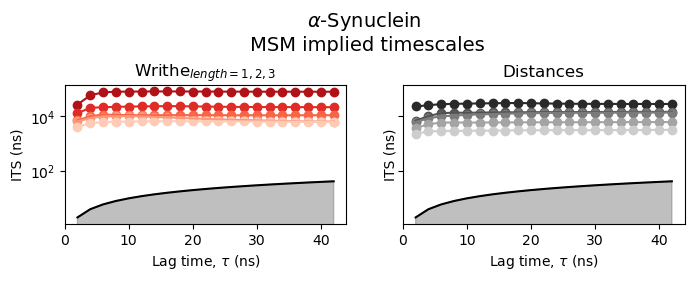

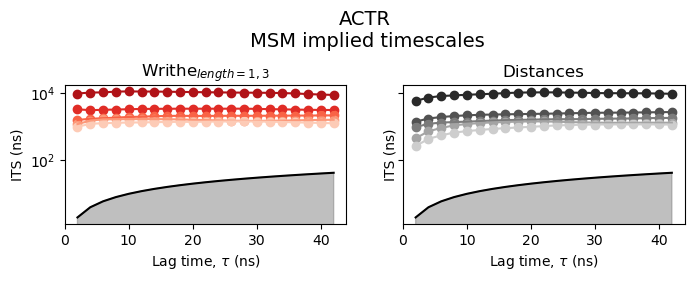

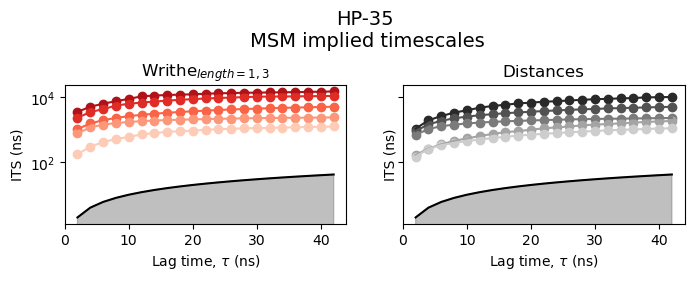

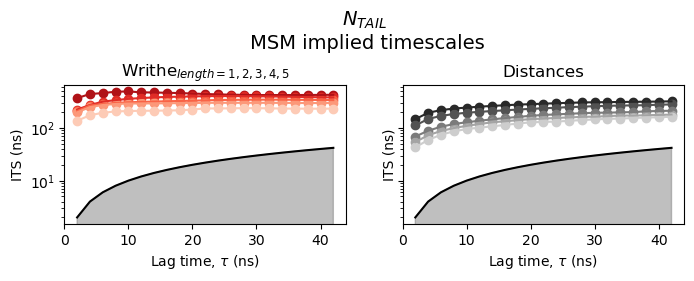

In [178]:
for name, length, (key, val) in zip(names, lengths,  msms.items()):
    l = ",".join(str(length))
    n_its = 5
    fig,axes = plt.subplots(1,2, figsize=(8,1.8), sharey=True)
    ax = axes.flat
    val["writhe"].its("msm", cmap="Reds_r", ax=ax[0], n_its=n_its)
    ax[0].set_title(f"Writhe$_{{length={l}}}$")
    val["distances"].its("msm", ax=ax[1], n_its=n_its, cmap="binary_r")
    ax[1].set_title("Distances")
    fig.suptitle(name+"\n MSM implied timescales", y=1.3, size = 14)

 # time scales for models estimated at converged lag times

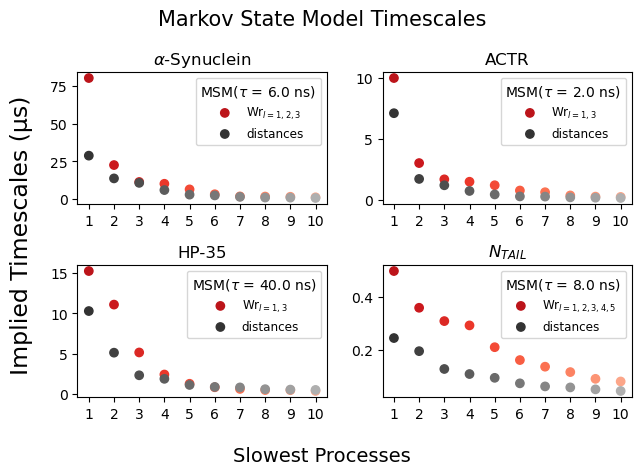

In [179]:
msm_lags = [3, 1, 20,4]
n_procs = 10
fig, axes = plt.subplots(2,2,figsize=(6.5,4.7))
for name, length, lag, ax,  (key, val) in zip(names, lengths, msm_lags, axes.flat,  msms.items()):
    w_its = val["writhe"].msm["its_est"][:n_procs, lag]/1000
    d_its = val["distances"].msm["its_est"][:n_procs, lag]/1000
    
    l = ",".join(str(length))
    wl = f"Wr$_{{l={l}}}$ "

    ax.scatter(np.arange(1,n_procs+1), w_its,
                color=visualize.get_color_list(n_procs, "Reds_r", trunc=80, pre_trunc=50),
                label=wl)

    ax.scatter(np.arange(1,n_procs+1).astype(int), d_its,
                color=visualize.get_color_list(n_procs, "binary_r", trunc=80, pre_trunc=50),
                label="distances")

    ax.set_xticks(np.arange(1,n_procs+1), np.arange(1,n_procs+1))
    
    
    ax.legend(title=rf"MSM($\tau$ = {lag*10*.2} ns)",fontsize=8.6)
    ax.set_title(name)

fig.supxlabel("Slowest Processes",size=14 )
fig.supylabel(f"Implied Timescales ({utils.symbols('mu')}s)", size=17)
fig.suptitle("Markov State Model Timescales", size=15)
fig.tight_layout()
#fig.savefig(f"/home/t/yahweh_all", dpi=1300, bbox_inches="tight")



# Overlay ITS (ugly)

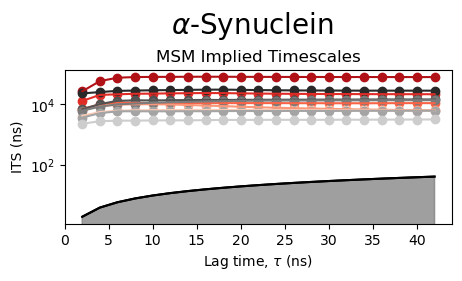

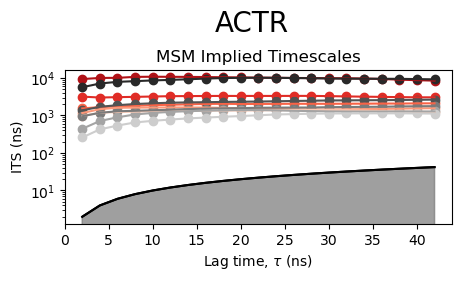

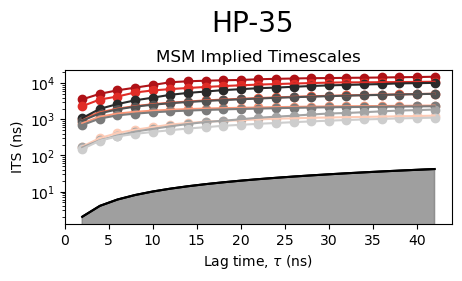

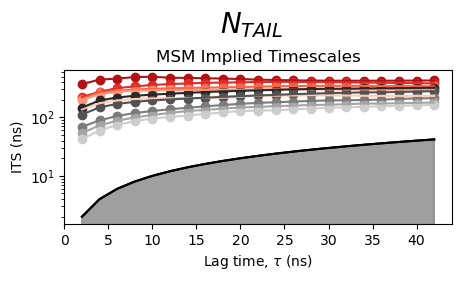

In [168]:
for name, length, (key, val) in zip(names, lengths,  msms.items()):
    l = ",".join(str(length))
    n_its = 5
    fig,ax = plt.subplots(1, figsize=(5,2), sharey=True)
    ax.set_title(f"Writhe$_{{length={length}}}$ ")
    val["writhe"].its("msm", cmap="Reds_r", ax=ax, n_its=n_its)
    #ax.set_title(f"Writhe$_{{length={length}}}$ ")
    val["distances"].its("msm", ax=ax, n_its=n_its, cmap="binary_r")
    ax.set_title("MSM Implied Timescales")
    fig.suptitle(name, y=1.18, size = 20)

 # General Visualizations and statistical summaries

obs = abs(Writhe.load("/home/t/writhe/asyn/full/apo/data/writhe/writhe_data_dict_length_5").writhe_features).sum(1)

frames_cl = utils.group_by(clusters["asyn"]["writhe"])
#frames_sort = utils.sort_indices_list(frames_cl, obs)
values, idx = utils.indices_stat(frames_cl, obs)
frames_sort = utils.reindex_list(frames_cl, idx)

import mdtraj as md
dcd = "/home/t/writhe/asyn/full/apo/asyn_apo_full.dcd"
pdb = "/home/t/writhe/asyn/asyn_full_lig47_trunc.protein.pdb"
trj = md.load(dcd, top=pdb)

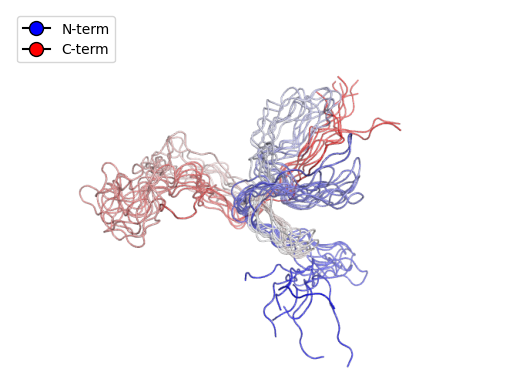

In [504]:
ax = plt.subplot(111)
image = visualize.make_structures(trj=trj.center_coordinates(),
                                  indices=frames_cl[4][:8],
                                  dir="/home/t/writhe/asyn/full/apo/",
                                  ensemble=True,
                                  name = "poster",
                                  overwrite=True,
                                  transparency=.2,
                                  palette="blue_gray90_red",
                                  ref=pdb)

visualize.plot_structure(image,
                         ax=ax)
plt.show()
    

; this can be computed by projecting pairs of vectors into the plane orthogonal to a third displacement vector that shares an endpoint with both (Column 2) such that the projected vector pair appear to share an endpoint. The angles between the projected vector pairs represent the orientation and extent to which each vector pair crosses one another as viewed from the perspective of the third mutually orthogonal vector. 

In [ ]:
n_closest = 10
palette = "blue_gray90_red"
nterm_color = palette.split("_")[0]
cterm_color = palette.split("_")[-1]

fig, axes  = plt.subplots(3,3,figsize=(15,15))
fig.suptitle(f"{protein_name} : Most Helical Clusters", fontsize=25, y=.96)

for i, salpha, pop, ax, indices in zip(sa_cl_idx,
                                      sa_cl_mean[sa_cl_idx],
                                      populations[sa_cl_idx],
                                      axes.flat, 
                                      list(map(sa_frames_cl.__getitem__, sa_cl_idx))):
    

    
    image = visualize.make_structures(trj=trj.center_coordinates(),
                                      indices=indices[:n_closest],
                                      dir=f"{out_dir}/images",
                                      ensemble=True,
                                      name = i,
                                      overwrite=True,
                                      transparency=.2,
                                      palette=palette,
                                      ref=pdb)

    visualize.plot_structure(image,
                             title = (f"{protein_name} Cluster : {i+1}\n"
                                      rf"$p$={pop}%"),
                             ax=ax)
    
    
